In [169]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from src.utils.visualization_utils import plot_points_as_histogramm

# Simulation of NFL Season 2015

As an example we simulate the NFL season 2015 with the schedule of that season

### Load schedule

Here we have the 2015 schedule of the NFL season containing all games that were played.
We want to simulate each game and assign a winner or a tie.

In [20]:
nfl_schedule_2015 = pd.read_csv("prepared_data/schedules/NFL/2015.csv")
nfl_schedule_2015.head()

,Home,Away
0,ARI,NO
1,ATL,PHI
2,BUF,IND
3,CHI,GB
4,DAL,NYG


### Assign a winner to each game

In this case the probabilities for winning, losing and a tie are [0.4999, 0.4999, 0.0002]

In [21]:
nfl_schedule_2015["Winner"] = np.random.choice(
    ["Home", "Away", "Tie"], size=len(nfl_schedule_2015), p=[0.4999, 0.4999, 0.0002]
)
nfl_schedule_2015["Outcome"] = nfl_schedule_2015.apply(
    lambda x: x["Home"]
    if x["Winner"] == "Home"
    else (x["Away"] if x["Winner"] == "Away" else "Tie"),
    axis=1,
)
nfl_schedule_2015.head()

,Home,Away,Winner,Outcome
0,ARI,NO,Home,ARI
1,ATL,PHI,Away,PHI
2,BUF,IND,Away,IND
3,CHI,GB,Home,CHI
4,DAL,NYG,Away,NYG


In [22]:
# Count the number of wins per team
win_counter = Counter(nfl_schedule_2015["Outcome"])

# As ties are unlikely to happen, it is possible that no ties occurred in the simulation
if "Tie" in win_counter:
    print("Tie")
    win_counter.pop("Tie")

# count the number of ties per team
tie_df = nfl_schedule_2015[nfl_schedule_2015["Outcome"] == "Tie"]
tie_list = list(tie_df["Home"].values) + list(tie_df["Away"].values)
tie_counter = Counter(tie_list)

# count the number of losses per team by subtracting the number of wins and ties from the number of games played for each team
loss_counter = (
    Counter(nfl_schedule_2015["Home"].values)
    + Counter(nfl_schedule_2015["Away"].values)
    - win_counter
    - tie_counter
)

### Visualize simulation results

To get the final table we need to calculate the overall points

$$ Points = Wins + 0.5*Ties $$

In [23]:
simulated_results_2015 = pd.DataFrame(
    [win_counter, loss_counter, tie_counter], index=["Wins", "Loses", "Ties"]
).T
# Replace NaN with 0 to avoid errors
simulated_results_2015.replace(np.nan, 0, inplace=True)
simulated_results_2015["Points"] = (
    simulated_results_2015["Wins"] + 0.5 * simulated_results_2015["Ties"]
)

#### Final table of simulated results

In [24]:
points = simulated_results_2015["Points"].values
simulated_results_2015.sort_values(by="Points", ascending=False)

,Wins,Loses,Ties,Points
NE,14.0,2.0,0.0,14.0
NYJ,12.0,4.0,0.0,12.0
GB,11.0,5.0,0.0,11.0
SF,11.0,5.0,0.0,11.0
NO,10.0,6.0,0.0,10.0
LAR,9.0,7.0,0.0,9.0
TEN,9.0,7.0,0.0,9.0
DET,9.0,7.0,0.0,9.0
ARI,9.0,7.0,0.0,9.0
JAX,9.0,7.0,0.0,9.0


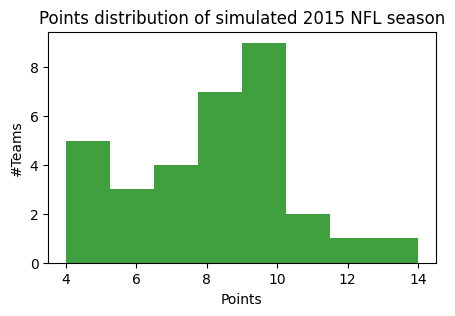

In [25]:
plot_points_as_histogramm(
    points,
    "Points distribution of simulated 2015 NFL season",
    stepsize=2,
    figsize=(5, 3),
)

### Calculate variance of the points

We calculate the sample variance of the final results (points). In order to make that value comparable across sports we min max scale the point vector first so the number of points per win and tie a team gets is irrelevant.

In [26]:
points_scaled = MinMaxScaler().fit_transform(points.reshape(-1, 1))
variance = np.var(points_scaled)
print(f"Variance: {variance}")

Variance: 0.04687500000000001


### Simulate results for 1000 seasons

In [27]:
from simulation_utils import simulate_league

sim_1000 = [
    simulate_league(
        nfl_schedule_2015,
        probabilities_win_loss_tie=[0.4999, 0.4999, 0.0002],
        points_for_win_loss_tie=[1, 0, 0.5],
        return_table=False,
        min_max_scaling=False,
    )
    for i in range(1000)
]

#### Plot some simulations

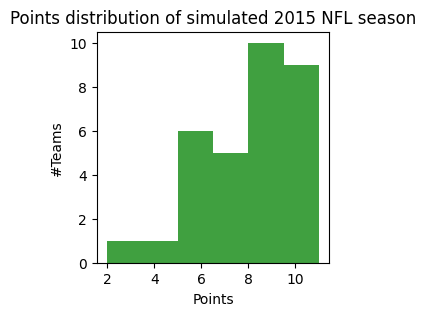

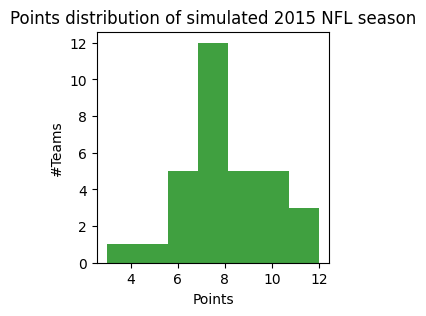

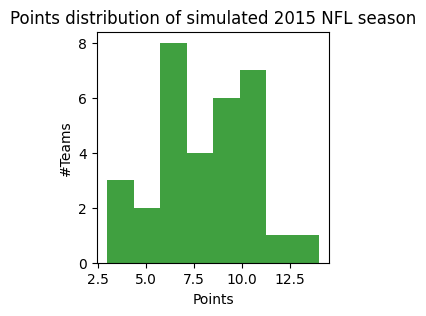

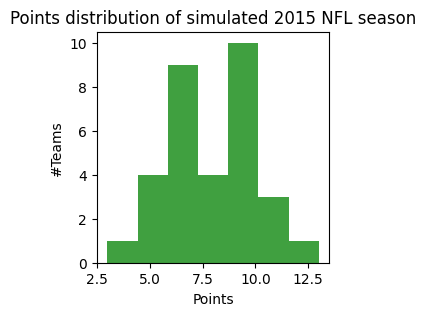

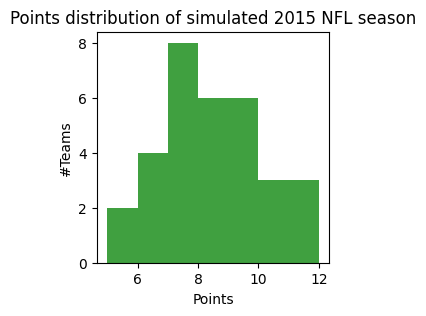

In [ ]:
for sim in sim_1000[:5]:
    plot_points_as_histogramm(
        sim,
        "Points distribution of simulated 2015 NFL season",
        stepsize=2,
        figsize=(3, 3),
    )

#### Calculate the average variance over the simulated season

In [30]:
sim_1000_scaled = [MinMaxScaler().fit_transform(sim.reshape(-1, 1)) for sim in sim_1000]
mean_var = np.mean([np.var(sim) for sim in sim_1000_scaled])

print(f"Mean variance: {mean_var}")

Mean variance: 0.060633506075699804


In [31]:
from simulation_utils import (
    simulate_league_multiple_times,
    calculate_variance_of_simulated_leagues,
)

In [32]:
sims_1000 = simulate_league_multiple_times(
    nfl_schedule_2015,
    probabilities_win_loss_tie=[0.4999, 0.4999, 0.0002],
    points_for_win_loss_tie=[1, 0, 0.5],
    return_table=False,
    min_max_scaling=True,
    n=1000,
)

In [33]:
calculate_variance_of_simulated_leagues(sims_1000)

0.06012380396695199

## Step by step climbing simulation

In [75]:
# load schedule
climbing_schedule = pd.read_csv("prepared_data/schedules/climbing/2021.csv")
climbing_observed = pd.read_parquet("prepared_data/climbing.parquet")
display(climbing_schedule.head())
display(climbing_observed.head())

,athlete_id,total_starter,name
0,1214,167,"IFSC - Climbing World Championships (B,L,S) - ..."
1,1214,174,"IFSC - Climbing World Cup (B,L) - Innsbruck (A..."
2,1361,167,"IFSC - Climbing World Championships (B,L,S) - ..."
3,1361,174,"IFSC - Climbing World Cup (B,L) - Innsbruck (A..."
4,1361,121,"IFSC - Climbing World Cup (L,S) - Villars (SUI..."


,Year,Teams,Wins,Losses,Ties
0,2007,"[7378, 5594, 7377, 4962, 6127, 5723, 7376, 335...","[0.014705882352941176, 0.029411764705882353, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2008,"[5838, 5961, 4966, 4812, 5914, 5928, 2929, 482...","[0.3465346534653465, 0.3564356435643564, 0.366...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2009,"[5986, 6029, 6028, 6027, 5973, 6025, 5017, 602...","[0.33636363636363636, 0.37272727272727274, 0.3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2010,"[1367, 5038, 5021, 5037, 5020, 5036, 3727, 501...","[0.3894736842105263, 0.4, 0.42028985507246375,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2011,"[6040, 6305, 3187, 5167, 5805, 3978, 6003, 172...","[0.36363636363636365, 0.37373737373737376, 0.3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [167]:
athletes_points = {}
for competition in climbing_schedule["name"].unique():
    ## for each athlete compute a random rank
    athletes_in_competition = climbing_schedule[
        climbing_schedule["name"] == competition
    ]["athlete_id"].unique()
    # each athlete has to do 5 boulders. He can top out on 0-5 of them. Each boulder has also a zone, which is also ranked. And then for each top and zone the number of tries are counted.
    tops = np.random.randint(0, 6, size=len(athletes_in_competition))
    zones = np.random.randint(0, 6, size=len(athletes_in_competition))
    tops_tries = [np.random.randint(top, 10) for top in tops]
    tops_tries = [max(1, top_tries) for top_tries in tops_tries]
    zones_tries = [np.random.randint(zone, 10) for zone in zones]
    zones_tries = [max(1, zone_tries) for zone_tries in zones_tries]
    points = [
        (top, zone, top_tries, zone_tries, athlete)
        for top, zone, top_tries, zone_tries, athlete in zip(
            tops, zones, tops_tries, zones_tries, athletes_in_competition
        )
    ]
    # order by tops then by zones, then by tries in ascending order
    points = sorted(points, key=lambda x: (-x[0], -x[1], x[2], x[3]))
    scores = [
        (top * 10) + (1 / top_tries) * 10 + zone + 1 / (zone_tries * 10)
        for top, zone, top_tries, zone_tries, ath in points
    ]
    points = [p + (s,) for p, s in zip(points, scores)]

    # for top, zone, top_tries, zone_tries, athlete, points in points:
    #     if athlete not in athletes_points:
    #         athletes_points[athlete] = [points]
    #     else:
    #         athletes_points[athlete].append(points)

In [168]:
points

[(5, 5, 5, 9, 854, 57.01111111111111),
 (5, 5, 5, 9, 12879, 57.01111111111111),
 (5, 5, 6, 5, 11390, 56.68666666666667),
 (5, 5, 6, 5, 12032, 56.68666666666667),
 (5, 5, 6, 9, 316, 56.67777777777778),
 (5, 4, 8, 6, 11546, 55.266666666666666),
 (5, 3, 6, 4, 3577, 54.69166666666666),
 (5, 3, 7, 6, 11684, 54.445238095238096),
 (5, 3, 7, 7, 634, 54.44285714285714),
 (5, 3, 8, 3, 912, 54.28333333333333),
 (5, 3, 9, 8, 1148, 54.12361111111112),
 (5, 2, 6, 8, 1251, 53.67916666666667),
 (5, 2, 7, 2, 3586, 53.47857142857143),
 (5, 2, 8, 3, 12310, 53.28333333333333),
 (5, 2, 9, 3, 1029, 53.144444444444446),
 (5, 1, 7, 4, 11647, 52.45357142857143),
 (5, 1, 7, 6, 1130, 52.445238095238096),
 (5, 1, 9, 5, 12863, 52.13111111111112),
 (5, 0, 7, 2, 3989, 51.47857142857143),
 (5, 0, 7, 4, 2381, 51.45357142857143),
 (4, 5, 7, 9, 914, 46.43968253968254),
 (4, 5, 8, 5, 3127, 46.27),
 (4, 5, 9, 5, 11534, 46.13111111111112),
 (4, 4, 5, 5, 12324, 46.02),
 (4, 4, 7, 4, 648, 45.45357142857143),
 (4, 4, 7, 4, 34

In [158]:
data = []
for athlete in athletes_points:
    data.append([athlete, np.mean(athletes_points[athlete])])
df = pd.DataFrame(data, columns=["Teams", "Wins"])
df["Losses"] = 0
df["Ties"] = 0
df["Points"] = df["Wins"]
df.head()

,Teams,Wins,Losses,Ties,Points
0,2309,552.200000,0,0,552.200000
1,3424,248.483466,0,0,248.483466
2,4018,371.869048,0,0,371.869048
3,4299,305.266336,0,0,305.266336
4,3211,541.777778,0,0,541.777778


In [78]:
from simulation_utils import simulate_climbing_season

sim_1000 = [
    simulate_climbing_season(
        climbing_schedule,
        probabilities_win_loss_tie=[0.4999, 0.4999, 0.0002],
        points_for_win_loss_tie=[1, 0, 0.5],
        return_table=False,
        min_max_scaling=False,
    )
    for i in range(10)
]

In [79]:
climbing_observed[climbing_observed["Year"] == 2021]["Wins"].values[0].shape, sim_1000[
    0
].shape

((350,), (350,))

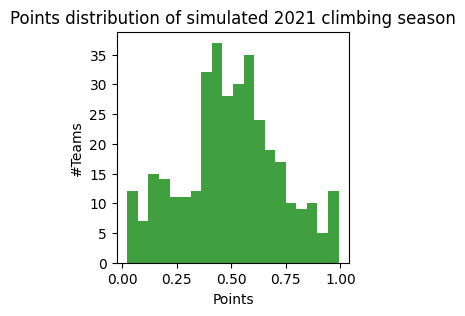

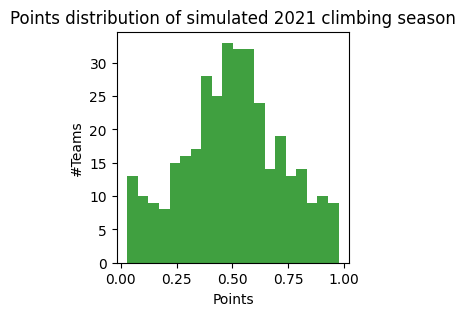

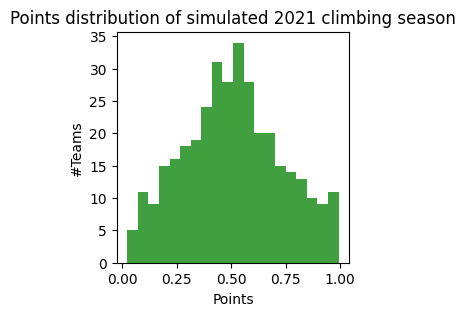

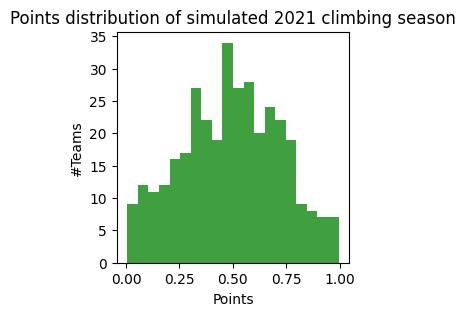

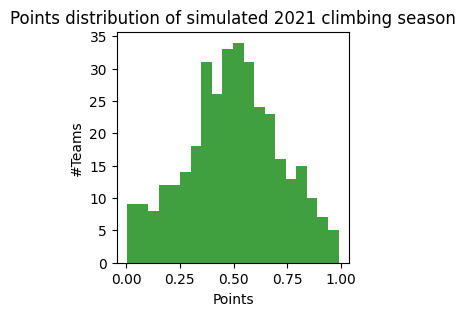

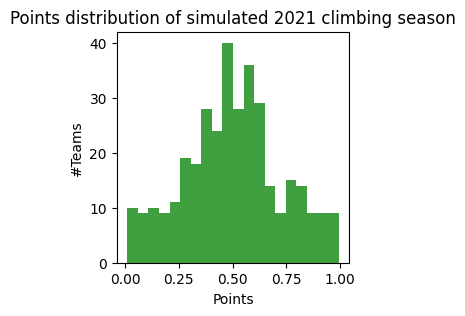

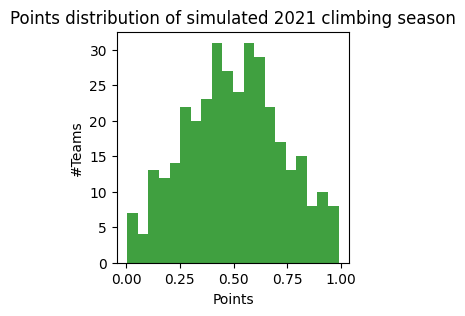

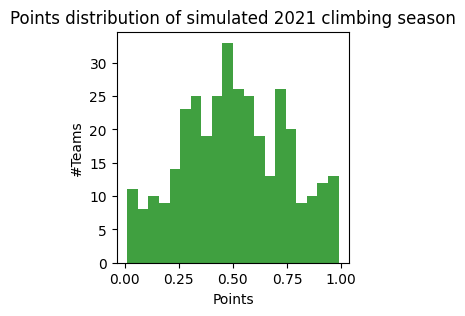

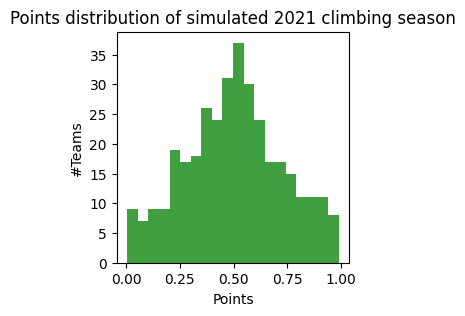

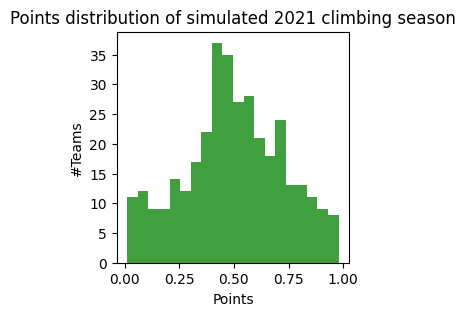

In [80]:
for sim in sim_1000:
    plot_points_as_histogramm(
        sim,
        "Points distribution of simulated 2021 climbing season",
        stepsize=0.1,
        figsize=(3, 3),
    )